page 66, kernel on Laplacian and normalised adjacency matrix

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import scipy as sc


In [2]:
G = nx.karate_club_graph()

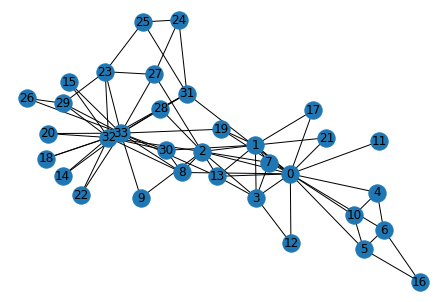

In [3]:
nx.draw(G, with_labels=True)

In [4]:
A = nx.adjacency_matrix(G)
A = A.toarray()
A

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]], dtype=int64)

# Normalising Matrix

In [26]:
# degree matrix
D = np.diag(list(dict(G.degree()).values()))
D_neg_half = sc.linalg.fractional_matrix_power(D, -1/2)
D

array([[16,  0,  0, ...,  0,  0,  0],
       [ 0,  9,  0, ...,  0,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  6,  0,  0],
       [ 0,  0,  0, ...,  0, 12,  0],
       [ 0,  0,  0, ...,  0,  0, 17]])

In [39]:
# normalised adjacency matrix
N = D_neg_half @ A @ D_neg_half
N

array([[0.        , 0.08333333, 0.07905694, ..., 0.10206207, 0.        ,
        0.        ],
       [0.08333333, 0.        , 0.10540926, ..., 0.        , 0.        ,
        0.        ],
       [0.07905694, 0.10540926, 0.        , ..., 0.        , 0.09128709,
        0.        ],
       ...,
       [0.10206207, 0.        , 0.        , ..., 0.        , 0.11785113,
        0.09901475],
       [0.        , 0.        , 0.09128709, ..., 0.11785113, 0.        ,
        0.070014  ],
       [0.        , 0.        , 0.        , ..., 0.09901475, 0.070014  ,
        0.        ]])

In [28]:
# laplacian matrix

# L = nx.linalg.laplacianmatrix.laplacian_matrix(G).toarray()
L = D - A
L

array([[16, -1, -1, ..., -1,  0,  0],
       [-1,  9, -1, ...,  0,  0,  0],
       [-1, -1, 10, ...,  0, -1,  0],
       ...,
       [-1,  0,  0, ...,  6, -1, -1],
       [ 0,  0, -1, ..., -1, 12, -1],
       [ 0,  0,  0, ..., -1, -1, 17]], dtype=int64)

In [40]:
# normalised laplacian matrix

Z = D_neg_half @ L @ D_neg_half
# Z = nx.linalg.normalized_laplacian_matrix(G).toarray()
Z

array([[ 1.        , -0.08333333, -0.07905694, ..., -0.10206207,
         0.        ,  0.        ],
       [-0.08333333,  1.        , -0.10540926, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07905694, -0.10540926,  1.        , ...,  0.        ,
        -0.09128709,  0.        ],
       ...,
       [-0.10206207,  0.        ,  0.        , ...,  1.        ,
        -0.11785113, -0.09901475],
       [ 0.        ,  0.        , -0.09128709, ..., -0.11785113,
         1.        , -0.070014  ],
       [ 0.        ,  0.        ,  0.        , ..., -0.09901475,
        -0.070014  ,  1.        ]])

In [60]:
"""
matrix power
check validity of spectral transformation
"""

def testMatrixPower(X, k=4):

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(X)

    # transform
    Xk_pred = U @ np.diag(V ** k) @ U.T
    Xk_pred = Xk_pred.real

    # number of paths 2nd neighbors
    Xk = np.linalg.matrix_power(X, k)

    return np.round(Xk - Xk_pred).sum()

testMatrixPower(A), testMatrixPower(N), testMatrixPower(L), testMatrixPower(Z)

(0.0, 0.0, -2.0, 0.0)

# Kernel

understand eigenvalue decomposition of N, L and Z

In [70]:
def testExponentialKernel(X, alpha=0.2):

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(X)

    # transform
    def transform(V, alpha=1):
        return np.array([np.exp(alpha*lamb) for lamb in V])

    expX_pred = U @ np.diag(transform(V, alpha)) @ U.T
    expX_pred = expX_pred.real

    # actual
    expX = sc.linalg.expm(X * alpha)

    return expX, expX_pred, np.round(expX - expX_pred).sum()

_, _, diff = testExponentialKernel(A)
print(diff)

# normalised exponential kernel 
expN, expN_pred, diff = testExponentialKernel(N)
print(diff)

# heat diffusion
_, heatPred, diff = testExponentialKernel(L, -0.2)
print(diff)

# normalized heat diffusion
_, normHeatPred, diff = testExponentialKernel(Z, -0.2)
print(diff)


0.0
6.0
2.0
0.0


In [78]:
def testNeumannKernel(X, alpha=0.01):

    # neumann inverse
    I = np.eye(X.shape[0])
    neu = np.linalg.inv(I - X * alpha)

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(X)

    # transform
    def transform(V, alpha):
        return np.array([1 / (1-(alpha*lamb)) for lamb in V])

    neu_pred = U @ np.diag(transform(V, alpha)) @ U.T
    neu_pred = neu_pred.real

    return neu, neu_pred, np.round(neu - neu_pred).sum()

# normalized neumann kernel
neuN, neuN_pred, diff = testExponentialKernel(N)
print(diff)

# regularized laplacian kernel
_, _, diff = testExponentialKernel(L, alpha=-0.01)
print(diff)

# normalized regularized laplacian kernel
_, _, diff = testExponentialKernel(Z, alpha=-0.01)
print(diff)


6.0
0.0
0.0


In [76]:
def testPathCountingKernel(X):

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(X)

    # transform
    V_ = V + V**2 + V**3 + V**4
    PC_pred = U @ np.diag(V_) @ U.T
    PC_pred = PC_pred.real

    # original
    PC = X + np.linalg.matrix_power(X, 2) + np.linalg.matrix_power(X, 3) + np.linalg.matrix_power(X, 4)

    return PC, PC_pred, np.round(PC - PC_pred).sum()

# normalized path counting (finite sum)
_, _, diff = testPathCountingKernel(N)
print(diff)

0.0

In [130]:
# Moore-Penrose pseudoinverse
def testPseudoinverseKernel(X):
    # moore-penrose pseudoinverse
    pi = np.linalg.pinv(X)

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(X)

    # transform
    def transform(V):
        # add 1e-10 instead of 0 as minimum because of rounding error
        return np.array([1/lamb if lamb > 1e-10 else 0 for lamb in V])

    pi_pred = U @ np.diag(transform(V)) @ U.T
    pi_pred = pi_pred.real

    return pi, pi_pred, np.round(pi - pi_pred).sum()

# commute-time kernel
pi, pred, diff = testPseudoinverseKernel(L)
print(diff)

# normalized commute-time kernel
pi, pred, diff = testPseudoinverseKernel(Z)
print(diff)


0.0
0.0


In [139]:
# generalized laplacian kernel (finite-power)
def testGeneralizedLaplacianKernel(X):

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(X)

    # transform
    V_ = V + V**2 + V**3 + V**4
    # inverse of sum
    def transform(V):
        # add 1e-10 instead of 0 as minimum because of rounding error
        return np.array([1/lamb if lamb > 1e-10 else 0 for lamb in V])
    V_ = transform(V_)
    PC_pred = U @ np.diag(V_) @ U.T
    PC_pred = PC_pred.real

    # original
    PC = X + np.linalg.matrix_power(X, 2) + np.linalg.matrix_power(X, 3) + np.linalg.matrix_power(X, 4)
    # pseudoinverse of sum
    PC = np.linalg.pinv(PC)

    return PC, PC_pred, np.round(PC - PC_pred).sum()

# normalized path counting (finite sum)
PC, PC_pred, diff = testGeneralizedLaplacianKernel(L)
diff

0.0

In [137]:
PC, PC_pred

(array([[ 0.01761461,  0.01023889, -0.00089142, ..., -0.01409291,
         -0.0189275 , -0.01693968],
        [ 0.01023889,  0.01288812,  0.00375672, ..., -0.00769641,
         -0.00893774, -0.00746827],
        [-0.00089142,  0.00375672,  0.00445076, ...,  0.00193765,
          0.00204654,  0.00255709],
        ...,
        [-0.01409291, -0.00769641,  0.00193765, ...,  0.01961947,
          0.01358987,  0.0126231 ],
        [-0.0189275 , -0.00893774,  0.00204654, ...,  0.01358987,
          0.02275268,  0.01980685],
        [-0.01693968, -0.00746827,  0.00255709, ...,  0.0126231 ,
          0.01980685,  0.01787758]]),
 array([[5.16619675e+13, 5.16619675e+13, 5.16619675e+13, ...,
         5.16619675e+13, 5.16619675e+13, 5.16619675e+13],
        [5.16619675e+13, 5.16619675e+13, 5.16619675e+13, ...,
         5.16619675e+13, 5.16619675e+13, 5.16619675e+13],
        [5.16619675e+13, 5.16619675e+13, 5.16619675e+13, ...,
         5.16619675e+13, 5.16619675e+13, 5.16619675e+13],
        ...,


In [145]:
# generalized normalized laplacian kernel

def testGeneralizedNormLaplacianKernel(Z):

    # eigenvalue decomposition. Don't use SVD, it doesn't return similar U and U.T
    V, U = np.linalg.eig(Z)

    # transform
    V_ = (1-V) + (1-V)**2 + (1-V)**3 + (1-V)**4
    PC_pred = U @ np.diag(V_) @ U.T
    PC_pred = PC_pred.real

    # original
    I = np.eye(Z.shape[0])
    PC = (I-Z) + np.linalg.matrix_power((I-Z), 2) + np.linalg.matrix_power((I-Z), 3) + np.linalg.matrix_power((I-Z), 4)

    return PC, PC_pred, np.round(PC - PC_pred).sum()

# normalized path counting (finite sum)
ori, pred, diff = testGeneralizedNormLaplacianKernel(Z)
print(diff)

0.0
